In [1]:
from pathlib import Path
import numpy as np
import cv2
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [2]:
os.chdir(r'D:\Machine Learning\Data\rsna-pneumonia-detection-challenge')

Read in the train labels

In [3]:
labels = pd.read_csv('stage_2_train_labels.csv')
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Drop any duplicates in the labels

In [4]:
labels = labels.drop_duplicates('patientId')

In [5]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed")

#### Visualize a few of the images

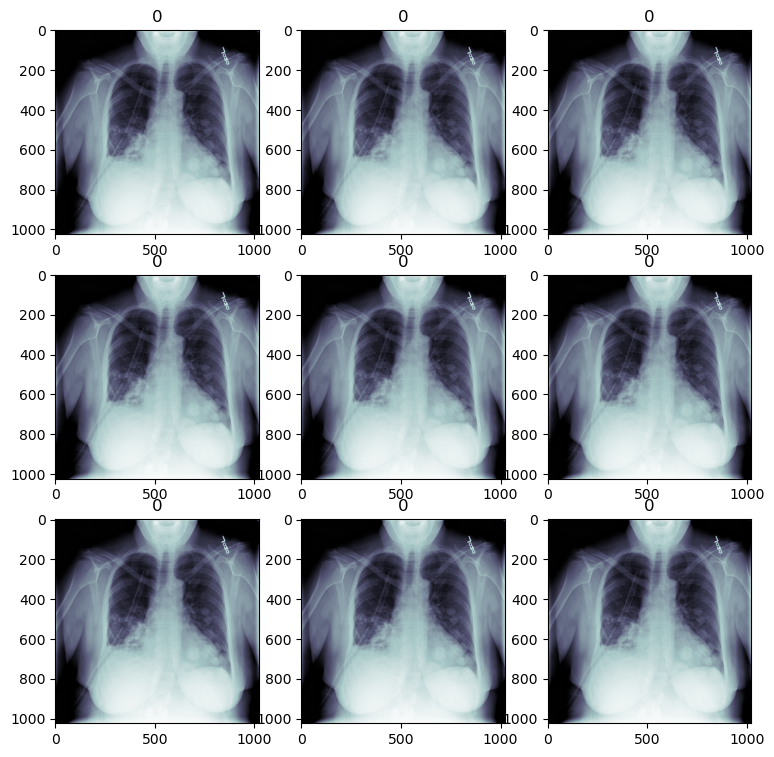

In [6]:
fig, ax = plt.subplots(3,3, figsize=(9,9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = labels['patientId'].iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        
        # the dicom image
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        # the label
        label = labels['Target'].iloc[c]
        
        ax[i][j].imshow(dcm, cmap='bone')
        ax[i][j].set_title(label)
        

## Calculate the mean and standard deviation of all the Training images for Standardizing

In [18]:
sums, sums_squared = 0, 0

for c, patiend_id in enumerate(tqdm(labels['patientId'])):
    patient_id = labels['patientId'].iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.read_file(dcm_path).pixel_array / 255   # Normalizing the data
    
    # resiize and save the file
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    
    label = labels['Target'].iloc[c]
    
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    
    normalizer = 224 * 224
    if train_or_val == "train":
        
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [19]:
mean = sums / 24000
std = np.sqrt(((sums_squared / 24000)) - mean **2)
mean, std

(0.4903962485384803, 0.24795070634161256)

## Create the Data folders and Transforms

In [7]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

In [8]:
os.chdir(r'D:\Machine Learning\Data\rsna-pneumonia-detection-challenge')

Function to load the numpy array files

In [9]:
def load_file(file):
    return np.load(file).astype(np.float32)

Create the transformation pipelines

In [10]:
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=0.49, std=0.248),
                        transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms   = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mean=0.49, std=0.248)
])

In [11]:
train_dataset = torchvision.datasets.DatasetFolder("Processed/train/", 
                                                   loader=load_file, 
                                                   extensions="npy",
                                                   transform=train_transforms)

val_dataset   = torchvision.datasets.DatasetFolder("Processed/val/", 
                                                   loader=load_file, 
                                                   extensions="npy",
                                                   transform=val_transforms)

Check that the data is loading and transforming correctly

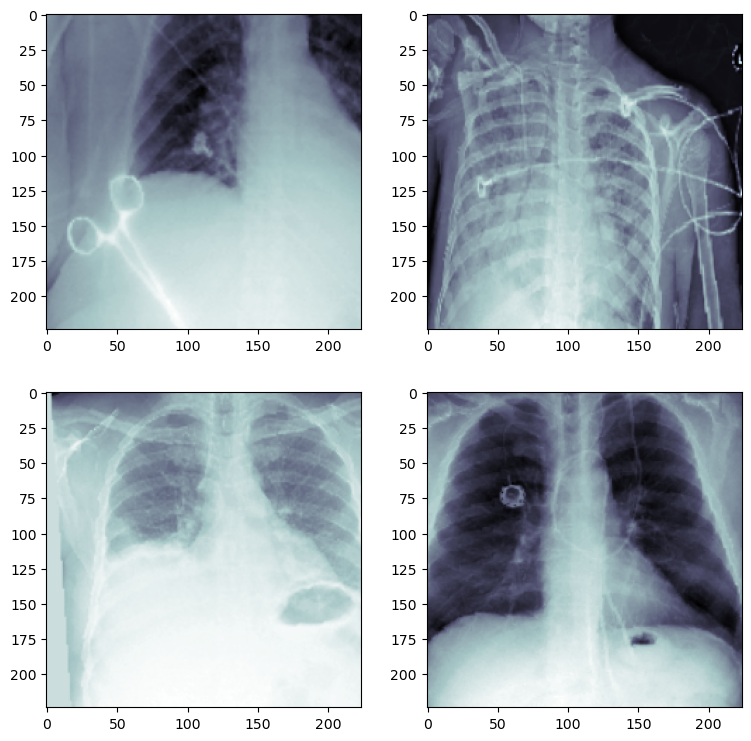

In [12]:
fig, ax = plt.subplots(2,2, figsize=(9,9))

for i in range(2):
    for j in range(2):
        
        random_idx = np.random.randint(0, 24000)
        data, label = train_dataset[random_idx]
        ax[i][j].imshow(data[0], cmap='bone')

## Creating the Data Loaders

Create the Data Loaders

In [14]:
BATCH_SIZE = 16
NUM_WORKERS = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Check the distribution of the classes

In [15]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407], dtype=int64))

There is a class imbalance. We shall use a class weightage to ovecome this imbalance

## Create the Model

We will use the Resnet18 model, and customize the input and output layers

In [16]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
class PneumoniaModel(pl.LightningModule):
    
    def __init__(self, weight=1):
        
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc    = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc   = torchmetrics.Accuracy(task='binary')
        
    def forward(self, data):
        
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Train loss", loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label.int()))
        
        return loss
    
    def training_epoch_end(self, outs):
        
        self.log("Train ACC", self.train_acc.compute())
        

    def validation_step(self, batch, batch_idx):
        
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)
        
        self.log("Val loss", loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label.int()))
        
    
    def validation_epoch_end(self, outs):
        
        self.log("Val ACC", self.val_acc.compute())
        
    def configure_optimizers(self):
        
        return [self.optimizer]


## Train the model

Define the model

In [18]:
model = PneumoniaModel()

Define the callbacks

In [19]:
checkpoint_callback = ModelCheckpoint(monitor="Val ACC", save_top_k=10, mode="max")

In [20]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, 
                     logger=TensorBoardLogger(save_dir='./logs'), 
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

C:\Users\amitr\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\amitr\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\amitr\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


## Model evaluation

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Load the last model

In [26]:
best_model = PneumoniaModel.load_from_checkpoint(r'logs\lightning_logs\version_7\checkpoints\epoch=34-step=52500.ckpt')
best_model.eval()
best_model.to(device);

Compute predictions

In [37]:
preds = []
labels = []

with torch.no_grad():
    
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(best_model(data)[0].cpu())
        
        preds.append(pred)
        labels.append(label)
        
preds = torch.Tensor(preds)
labels = torch.Tensor(labels)        

  0%|          | 0/2684 [00:00<?, ?it/s]

In [70]:
acc = np.round(torchmetrics.Accuracy(task='binary')(preds, labels).numpy() * 100, 2)
precision = np.round(torchmetrics.Precision(task='binary')(preds, labels).numpy() * 100, 2)
recall = np.round(torchmetrics.Recall(task='binary')(preds, labels).numpy() * 100, 2)

conf_matrix = torchmetrics.ConfusionMatrix(task='binary')(preds, labels)

print(f"\nValidation : Accuracy {acc}   Precision {precision}   Recall {recall}")
print("\nConfusion Matrix : \n\n", conf_matrix)


Validation : Accuracy 84.95   Precision 66.67   Recall 66.45

Confusion Matrix : 

 tensor([[1878,  201],
        [ 203,  402]])
